In [1]:
cd ../analysis/

/home/jlee782/hcomp_paper_seg/analysis


In [2]:
%pylab inline
%load_ext autoreload
%autoreload 2
from hcomp_paper_viz import *

Populating the interactive namespace from numpy and matplotlib


/home/jlee782/.local/lib/python2.7/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [4]:
from qualityBaseline import compute_self_BBvals
print "generate baseline comparisons"
compute_self_BBvals(compute_metrics=['simple','area'])

generate baseline comparisons


/home/jlee782/.local/lib/python2.7/site-packages/pandas/io/parsers.py:648: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skip_footer; you can avoid this warning by specifying engine='python'.
  ParserWarning)


In [89]:
# myBBvals = pd.read_csv("../data/computed_my_COCO_BBvals.csv")

In [11]:
from  analysis_toolbox import load_info

In [12]:
img_info,object_tbl,bb_info,hit_info = load_info()

/home/jlee782/.local/lib/python2.7/site-packages/pandas/io/parsers.py:648: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skip_footer; you can avoid this warning by specifying engine='python'.
  ParserWarning)


In [23]:
from qualityBaseline import *
from collections import OrderedDict

  1%|          | 18/1782 [00:00<01:28, 19.91it/s]/home/jlee782/.local/lib/python2.7/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
  2%|▏         | 36/1782 [00:01<01:29, 19.48it/s]

KeyboardInterrupt: 

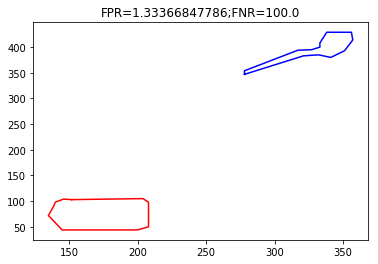

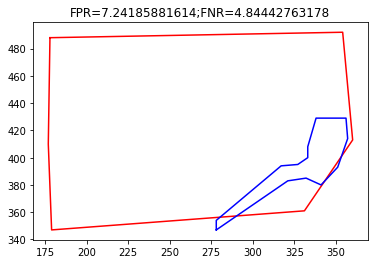

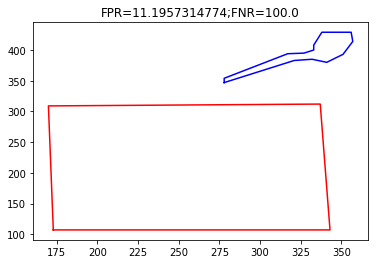

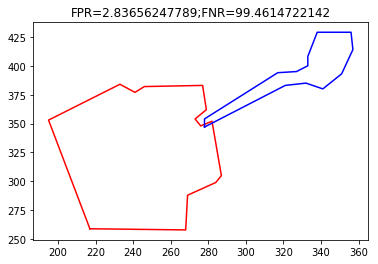

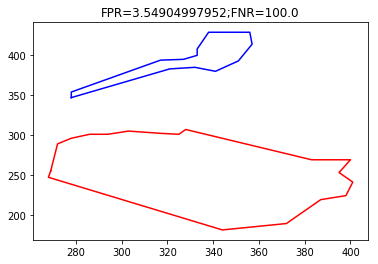

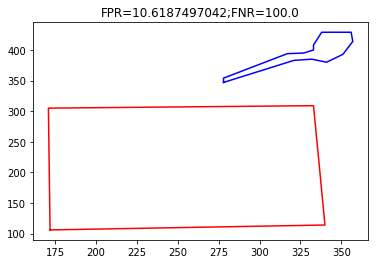

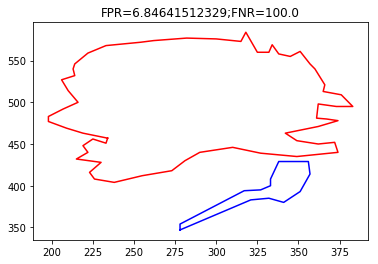

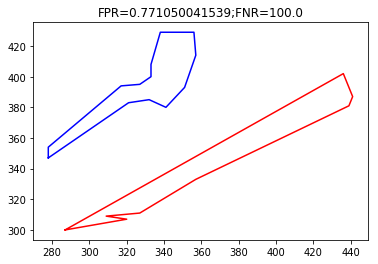

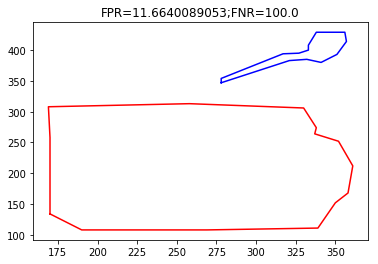

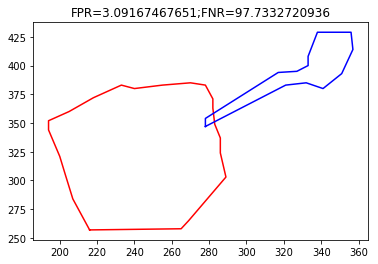

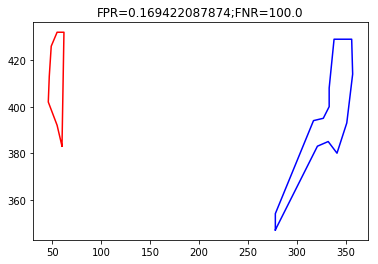

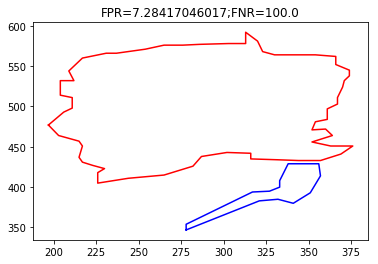

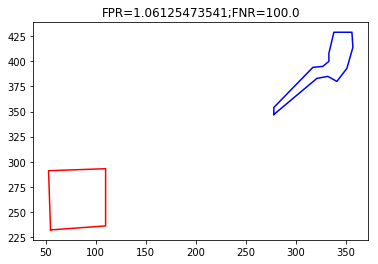

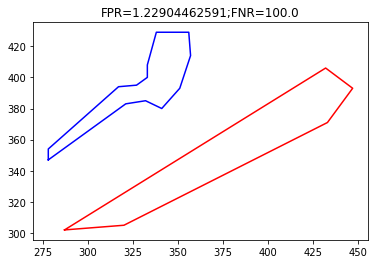

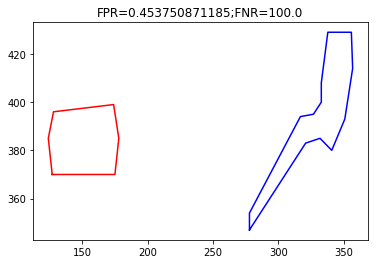

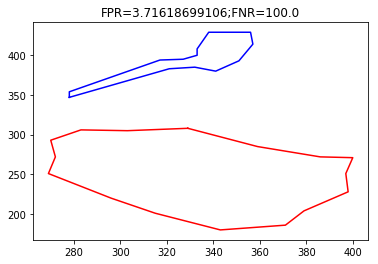

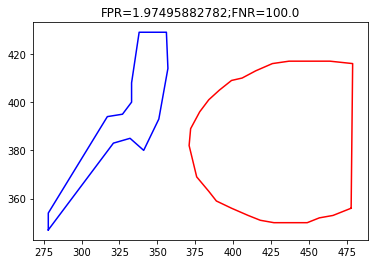

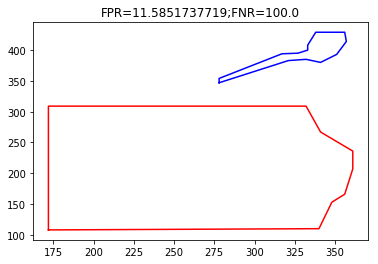

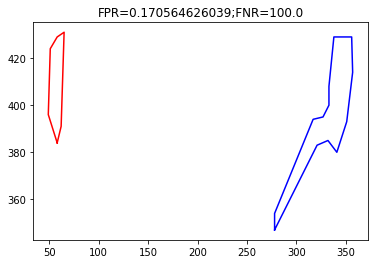

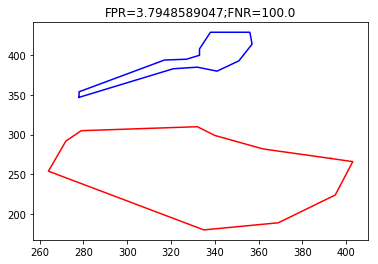

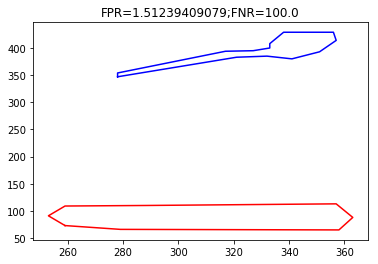

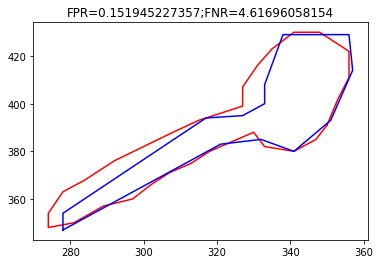

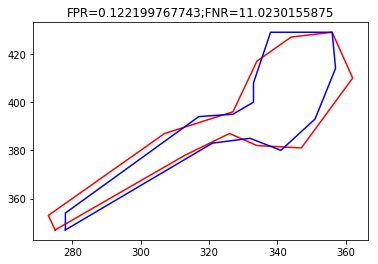

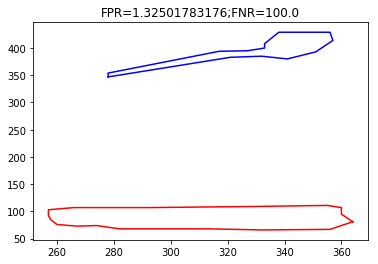

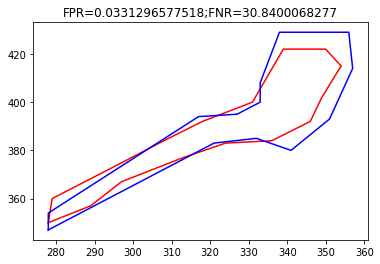

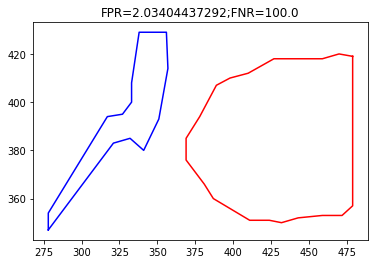

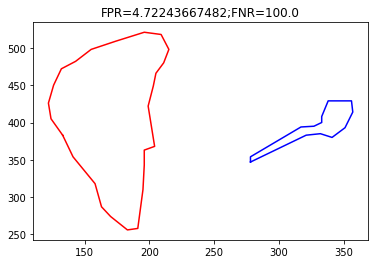

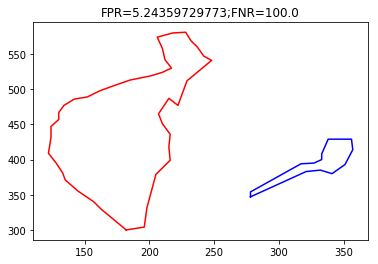

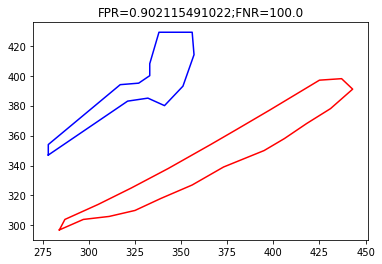

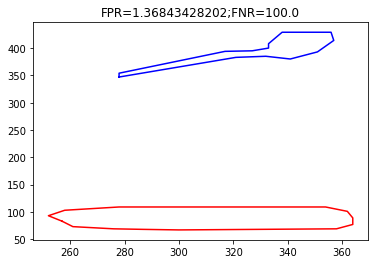

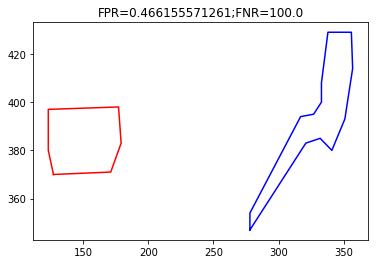

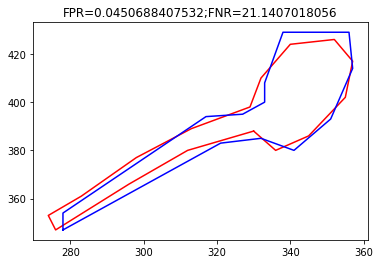

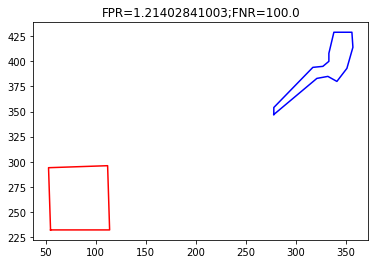

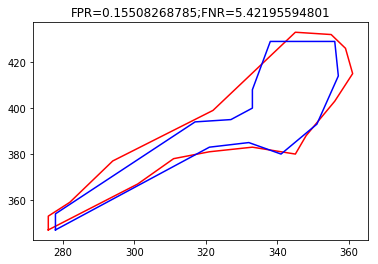

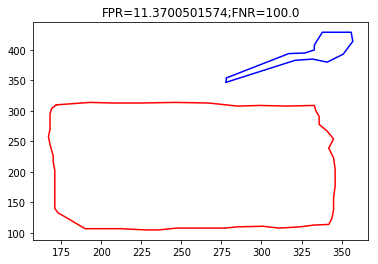

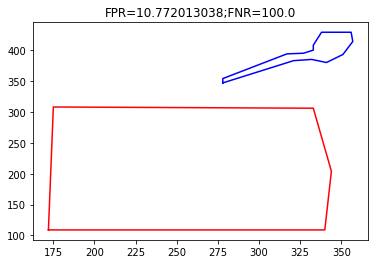

In [83]:
oid=11
for bb in tqdm(list(bb_info.iterrows())):
    image_id = int(object_tbl[object_tbl.object_id==oid].image_id)
    img_name = img_info["filename"][image_id-1]
    bbx_path= bb[1]["x_locs"]
    bby_path= bb[1]["y_locs"]
    worker_x_locs,worker_y_locs= process_raw_locs([bbx_path,bby_path])
    worker_x_locs,worker_y_locs = zip(*list(OrderedDict.fromkeys(zip(worker_x_locs,worker_y_locs))))
    my_BBG  = pd.read_csv("../data/my_ground_truth.csv")
    my_ground_truth_match = my_BBG[my_BBG.object_id==oid]
    my_x_locs,my_y_locs =  process_raw_locs([my_ground_truth_match["x_locs"].iloc[0],my_ground_truth_match["y_locs"].iloc[0]])
    my_x_locs,my_y_locs = zip(*list(OrderedDict.fromkeys(zip(my_x_locs,my_y_locs))))
    obj_x_locs = [list(worker_x_locs),list(my_x_locs)]
    obj_y_locs = [list(worker_y_locs),list(my_y_locs)]
    if DEBUG: 
        from calc_Tstar import plot_coords
        plt.figure()
        FPR,FNR = TFPNR(img_name,obj_x_locs,obj_y_locs)
        plt.title("FPR={};FNR={}".format(FPR,FNR))
        print "red : worker ; blue: ground truth"
        plot_coords(Polygon(zip(obj_x_locs[0],obj_y_locs[0])).buffer(0))
        plot_coords(Polygon(zip(obj_x_locs[1],obj_y_locs[1])).buffer(0),color="blue")

In [79]:
def TFPNR(img_name,obj_x_locs,obj_y_locs):
    # True False Positive Negative Rates
    # as defined in https://en.wikipedia.org/wiki/Sensitivity_and_specificity#Definitions
    polygon1 = Polygon(zip(obj_x_locs[0],obj_y_locs[0])).buffer(0)
    polygon2 = Polygon(zip(obj_x_locs[1],obj_y_locs[1])).buffer(0)
    img_name = "../web-app/app/static/"+img_name+".png"
    intersection_area = intersection(obj_x_locs,obj_y_locs)
    result_area = polygon1.area    
    gt_area = polygon2.area


    TP = intersection_area
    FP = result_area - intersection_area
    FN = gt_area - intersection_area
    TN = np.product(get_size(img_name)) - (gt_area+result_area-intersection_area)

    FPR = FP/float(FP+TN)
    FNR = FN/float(TP+FN)
    return FPR*100, FNR*100

In [80]:
from calc_Tstar import plot_coords

(1.4029298243204262, 100.0)

In [ ]:

def TFPNR(result, gt):
    # True False Positive Negative Rates
    # as defined in https://en.wikipedia.org/wiki/Sensitivity_and_specificity#Definitions
    intersection = len(np.where(((result == 1) | (gt == 1)) & (result == gt))[0])
    gt_area = float(len(np.where(gt == 1)[0]))
    result_area = float(len(np.where(result == 1)[0]))

    TP = intersection
    FP = result_area - intersection
    FN = gt_area - intersection
    TN = np.product(np.shape(result)) - (gt_area+result_area-intersection)

    #TPR = TP/float(TP+FN)
    FPR = FP/float(FP+TN)
    FNR = FN/float(TP+FN)
    #TNR = TN/float(TN+FP)
    #assert TPR+FNR==1 and TNR+FPR==1

    #return  TPR,TNR#,FNR,TNR,FPR
    return FPR*100, FNR*100


In [84]:
NworkerPerformance = df.groupby("num_workers").mean()

In [85]:
metric_J_baselines=["J [NumPt]","J [AreaRatio]","J [AvrgWorker]","J [BestWorker]"]

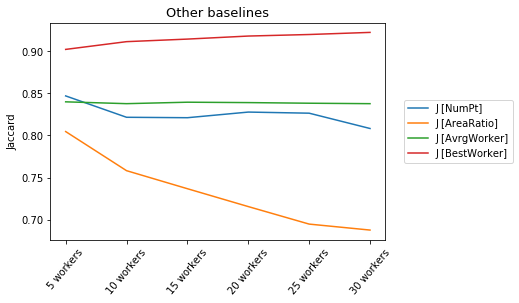

In [86]:
for algo in metric_J_baselines:
    plt.plot(np.array(NworkerPerformance[algo]),label=algo)
plt.legend(bbox_to_anchor=(1.04,0.5),loc="center left")    
plt.ylabel("Jaccard")
plt.xticks(rotation=50)
plt.title("Other baselines",fontsize=13)
a = gca().set_xticklabels([0,'5 workers','10 workers','15 workers','20 workers','25 workers','30 workers'])

In [117]:
from withClustAnalysis import *
best_clust_df = best_worker_picking()
clustObj=clust_df.objid.unique()
def plot_best_clust_thresh_metric(metric,gt="",includeObjs=[],plot_noClustMV=True):
    for algo in ['GTLSA',"basic","GT","isoGT","isoGTLSA"]:
        # we only ran on the best clusters, so the results should only be on the best clusters if not -1
        data =  pd.read_csv("pixel_em/{}{}_full_PRJ_table.csv".format(gt,algo))
        data = data[((data["clust"]==-1) &(data["objid"].isin(noClust_obj)))| ((data["clust"]!=-1) & data["objid"].isin(clustObj))]
        if includeObjs!=[]:
            data = data[data["objid"].isin(includeObjs)]
        #data = data[data["sample_num"]==0]
        plt.plot(np.array(data.groupby("num_workers").mean()[metric]),label=algo)
    print len(data.groupby("num_workers").mean()[metric])
    MV = pd.read_csv("pixel_em/MV_full_PRJ_table.csv") 
    #MV = MV[MV["sample_num"]==0]
    # now need to filter based on best cluster
    MV = filter_best_clust(MV,best_clust_df)
    if includeObjs!=[]:
        MV = MV[MV["objid"].isin(includeObjs)]
    # select only the best cluster if clustered object -1 if not clustered
    MV_withClust = MV[((MV["clust"]==-1) &(MV["objid"].isin(noClust_obj)))| ((MV["clust"]!=-1) & MV["objid"].isin(clustObj))]
    plt.plot(np.array(MV_withClust.groupby("num_workers").mean()[metric]),label="MV clust",color="cyan",linestyle="--")
    if plot_noClustMV:
        MV_noClust = MV[(MV["clust"]==-1) &(MV["objid"].isin(noClust_obj))].groupby("num_workers").mean()[metric]
        plt.plot(np.array(MV_noClust),label="MV no clust",color="black",linestyle="--")

    plt.legend(bbox_to_anchor=(1.04,0.5),loc="center left")    
    plt.ylabel(metric)
    plt.xticks(rotation=50)
    a = gca().set_xticklabels([0,'5 workers','10 workers','15 workers','20 workers','25 workers','30 workers'])
    if gt:
        plt.title("Ground truth EM [best clust & thresh]",fontsize=13)
    else:
        plt.title("Binary Search Thresh EM [best clust & thresh]",fontsize=13)

6


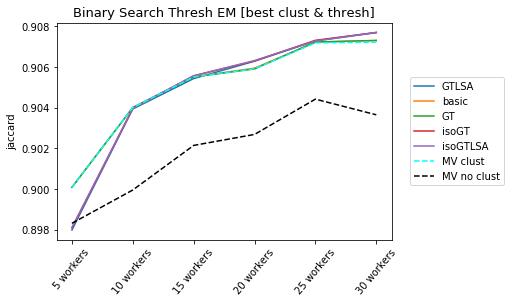

In [118]:
plot_best_clust_thresh_metric("jaccard")

6
6


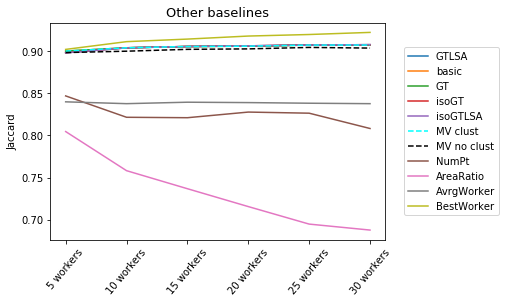

In [121]:
plot_best_clust_thresh_metric("jaccard")

for algo in metric_J_baselines:
    plt.plot(range(6),np.array(NworkerPerformance[algo]),label=algo[3:-1])
print len(np.array(NworkerPerformance[algo]))
plt.legend(bbox_to_anchor=(1.04,0.5),loc="center left")    
plt.ylabel("Jaccard")
plt.xticks(rotation=50)
plt.title("Other baselines",fontsize=13)


# gt-est by best worker picking based on worker quality, also correlation with individual worker

In [197]:
df = pd.read_csv("../data/computed_my_COCO_BBvals.csv",index_col=0)

In [198]:
df= df[df["worker_id"]!=3]

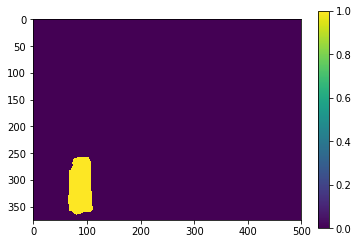

In [158]:
plt.imshow(pkl.load(open("pixel_em/obj22/mask24.pkl")))
plt.colorbar()

In [160]:
# pd.set_option('display.height', 500)
# pd.set_option('display.max_rows', 500)
# df[["object_id","worker_id","Jaccard [Self]","Precision [Self]","Recall [Self]"]]

In [161]:
for row in df.iterrows():
    row = row[1]
    row[["object_id","worker_id","Jaccard [Self]","Precision [Self]","Recall [Self]","FPR [Self]","FNR [Self]"]]

In [162]:
row[["object_id","worker_id","Jaccard [Self]","Precision [Self]","Recall [Self]","FPR [Self]","FNR [Self]"]]

object_id                    10
worker_id                   139
Jaccard [Self]        0.9484793
Precision [Self]      0.9805065
Recall [Self]         0.9667082
FPR [Self]          0.001097399
FNR [Self]           0.01921914
Name: 1946, dtype: object

In [200]:
df=pd.read_csv("../data/bounding_box.csv")

In [203]:
from analysis_toolbox import load_info
img_info,object_tbl,bb_info,hit_info = load_info()

/home/jlee782/.local/lib/python2.7/site-packages/pandas/io/parsers.py:648: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skip_footer; you can avoid this warning by specifying engine='python'.
  ParserWarning)


In [204]:
bb_info[bb_info["worker_id"]==2]

,object_id,worker_id,x_locs,y_locs
183,9,2,"[257, 353, 380, 383, 385, 309, 294, 284, 269, ...","[219, 191, 232, 252, 279, 288, 278, 269, 268, ..."
1891,12,2,"[304, 307, 308, 381, 394, 402, 402, 310]","[292, 311, 323, 439, 443, 440, 431, 301]"
1892,10,2,"[393, 411, 440, 472, 520, 541, 539, 537, 537, ...","[237, 228, 224, 225, 238, 257, 270, 278, 285, ..."


In [201]:
df[df["worker_id"]==2]

,object_id,worker_id,x_locs,y_locs
183,9,2,"[257, 353, 380, 383, 385, 309, 294, 284, 269, ...","[219, 191, 232, 252, 279, 288, 278, 269, 268, ..."
1891,12,2,"[304, 307, 308, 381, 394, 402, 402, 310]","[292, 311, 323, 439, 443, 440, 431, 301]"
1892,10,2,"[393, 411, 440, 472, 520, 541, 539, 537, 537, ...","[237, 228, 224, 225, 238, 257, 270, 278, 285, ..."


In [243]:
from qualityBaseline import *

In [244]:
img_info,object_tbl,bb_info,hit_info = load_info()

In [245]:
def compute_self_BBvals(compute_metrics=['simple','area','dist']):
    #compute_metrics=["Num Points", 'Precision [Self]','Recall [Self]','Jaccard [Self]',"NME [Self]","Area Ratio"]
    from analysis_toolbox import *
    from collections import OrderedDict
    '''
    Selectively compute metrics and store into computed_my_COCO_BBvals.csv
    'simple': simple baselines [Point,Size]
    'area': Area based metrics [Precision, Recall, Jaccard index]
    'distance': Distance based metrics [MunkresEuclidean]
    '''
    if len(compute_metrics)==3: print "Note: It will take about 2 hours to compute all metrics for all workers"
    save_db_as_csv(connect=False)
    #If we are recomputing everything, then load brand new bb_info table
    img_info,object_tbl,bb_info,hit_info = load_info()
    ground_truth = pd.read_csv("../data/object_ground_truth.csv")
    my_BBG  = pd.read_csv("../data/my_ground_truth.csv")

    for bb in tqdm(list(bb_info.iterrows())):

        oid = bb[1]["object_id"]
        #Image information
        image_id = int(object_tbl[object_tbl.object_id==oid].image_id)
        img_name = img_info["filename"][image_id-1]

        bbx_path= bb[1]["x_locs"]
        bby_path= bb[1]["y_locs"]
        worker_x_locs,worker_y_locs= process_raw_locs([bbx_path,bby_path])
        worker_x_locs,worker_y_locs = zip(*list(OrderedDict.fromkeys(zip(worker_x_locs,worker_y_locs))))
        #Simple Baseline Measures
        if 'simple' in compute_metrics:
            bb_info = bb_info.set_value(bb[0],"Num Points",len(worker_x_locs))
            bb_info = bb_info.set_value(bb[0],"Area Ratio",compute_img_to_bb_area_ratio(img_name,worker_x_locs,worker_y_locs))
        if ('area' in compute_metrics) or ('dist' in compute_metrics):
            
            # Comparing with SELF ground truth
            my_ground_truth_match = my_BBG[my_BBG.object_id==oid]
            my_x_locs,my_y_locs =  process_raw_locs([my_ground_truth_match["x_locs"].iloc[0],my_ground_truth_match["y_locs"].iloc[0]])
            my_x_locs,my_y_locs = zip(*list(OrderedDict.fromkeys(zip(my_x_locs,my_y_locs))))
            obj_x_locs = [list(worker_x_locs),list(my_x_locs)]
            obj_y_locs = [list(worker_y_locs),list(my_y_locs)]
            if ('area' in compute_metrics):
                bb_info = bb_info.set_value(bb[0],"Jaccard [Self]",jaccard(obj_x_locs,obj_y_locs))
                bb_info = bb_info.set_value(bb[0],"Precision [Self]",precision(obj_x_locs,obj_y_locs))
                bb_info = bb_info.set_value(bb[0],"Recall [Self]",recall(obj_x_locs,obj_y_locs))
    #Drop Unnamed columns (index from rewriting same file)
    bb_info = bb_info[bb_info.columns[~bb_info.columns.str.contains('Unnamed:')]]
    # replace all NAN values with -1, these are entries for which we don't have COCO ground truth
    bb_info = bb_info.fillna(-1)
    bb_info.to_csv("computed_my_COCO_BBvals.csv")

<ipython-input-245-3563f89a7313>:1: SyntaxWarning: import * only allowed at module level
  def compute_self_BBvals(compute_metrics=['simple','area','dist']):


In [246]:
compute_self_BBvals(compute_metrics=['simple','area'])

In [238]:
def jaccard(obj_x_locs,obj_y_locs):
    '''
    Jaccard Simmilarity or Overlap Method
    used for PASCAL VOC challenge
    '''
    return intersection(obj_x_locs,obj_y_locs)/union(obj_x_locs,obj_y_locs)

In [253]:
pwd

u'/home/jlee782/final_segmentation/analysis'

In [254]:
df =pd.read_csv("../../hcomp_paper_seg/data/computed_my_COCO_BBvals.csv",index_col=0)

In [255]:
df[df["worker_id"]==2]

,object_id,worker_id,x_locs,y_locs,Num Points,Area Ratio,Jaccard [Self],Precision [Self],Recall [Self]


cleaning out 2 from object 9,10,12 all samples

In [ ]:
rm -r pixel_em/*/obj9
rm -r pixel_em/*/obj10
rm -r pixel_em/*/obj12
rm pixel_em/obj*/mask2.pkl

In [257]:
from initPixelAnalysis import *

generate baseline comparisons


In [ ]:
for sample in sample_lst:
    for objid in [9,10,12]:
        print sample + ":" + str(objid)
        create_mega_mask(objid, PLOT=False, sample_name=sample)

In [ ]:
df = pd.read_csv("spectral_clustering_all_hard_obj.csv")
print "3.Creating megamask (aggregated mask over all workers in that sample) for all sample-objects [mega_mask.pkl, voted_workers_mask.pkl]"
print "This might take a while (~1hrs)"
for sample in sample_lst:
    for objid in [9,10,12]:
        cluster_ids = df[(df["objid"] == objid)].cluster.unique()
        for cluster_id in cluster_ids:
            print sample + ":" + str(objid) + "; clust:" + str(cluster_id)
            create_mega_mask(objid,cluster_id=cluster_id, PLOT=False, sample_name=sample)

In [ ]:
mv_prj_vals = []
for batch in sample_lst:
    for objid in [9,10,12]:
        cluster_ids = df[(df["objid"] == objid)].cluster.unique()
        if len(cluster_ids)==0: #no cluster case
            cluster_ids=["-1"]
        for clust in cluster_ids:
            print batch + ":" + str(objid)+";clust"+str(clust)
            if clust=="-1":
                hydir = '{}{}/obj{}/'.format(PIXEL_EM_DIR, batch, objid)
            else:
                hydir = '{}{}/obj{}/clust{}/'.format(PIXEL_EM_DIR, batch, objid,clust)
            worker_ids = json.load(open(hydir+"worker_ids.json"))
            p, r, j = compute_PRJ_MV(batch, objid,cluster_id=clust)
            mv_prj_vals.append([batch, objid, clust, p, r, j])
mv_df = pd.DataFrame(mv_prj_vals, columns=["sample", "objid", "clust", "MV_precision", "MV_recall", "MV_jaccard"])
mv_df.to_csv("pixel_em/MV_full_PRJ_table.csv")

In [278]:
best_clust = compute_best_worker_picking()

In [279]:
obj_clusters = clusters()

In [ ]:
for sample in tqdm(sample_lst):
    for objid in [9,10,12]:
        if os.path.exists("pixel_em/{}/obj{}/tiles.pkl".format(sample, objid)):
            print sample+":"+str(objid)+" already exist"
        else:
            print sample + ":" + str(objid)
            create_PixTiles(sample, objid, check_edges=True)
    for objid in [9,10,12]:
        cluster_ids = df[(df["objid"] == objid)].cluster.unique()
        for cluster_id in cluster_ids:
            worker_ids = np.array(df[(df["objid"] == objid) & (df["cluster"] == cluster_id)].wid)
            if len(worker_ids) != 1:
                print sample + ":" + str(objid)+"clust"+str(cluster_id)
                create_PixTiles(sample, objid, cluster_id, check_edges=True)

In [275]:
cd ../../hcomp_paper_seg/analysis/

/home/jlee782/hcomp_paper_seg/analysis


In [276]:
MV_clust = pd.read_csv("pixel_em/MV_full_PRJ_table.csv",index_col=0)

In [277]:
len(MV_clust)

2480

In [282]:
cd ../../final_segmentation/analysis/

/home/jlee782/final_segmentation/analysis


In [288]:
df[df["object_id"]==7]

,object_id,worker_id,x_locs,y_locs,Num Points,Area Ratio,Jaccard [Self],Precision [Self],Recall [Self]
156,7,92,"[360, 364, 368, 379, 390, 399, 407, 406, 402, ...","[162, 156, 137, 125, 123, 124, 137, 146, 159, ...",17,0.009969,0.595807,0.905263,0.635427
182,7,106,"[424, 415, 405, 405, 387, 375, 365, 361, 361, ...","[195, 162, 158, 131, 118, 124, 141, 151, 158, ...",10,0.009272,0.501476,0.845553,0.552042
186,7,84,"[358, 375, 403, 409, 427, 414, 372]","[157, 121, 119, 156, 191, 222, 219]",7,0.015972,0.828932,0.856261,0.962925
219,7,114,"[423, 421, 416, 407, 404, 404, 403, 400, 391, ...","[188, 177, 169, 157, 147, 139, 133, 121, 119, ...",22,0.009491,0.495857,0.827552,0.552997
263,7,68,"[404, 413, 418, 421, 421, 417, 410, 400, 387, ...","[158, 161, 172, 181, 191, 197, 190, 188, 184, ...",22,0.008494,0.520961,0.915205,0.547382
268,7,234,"[392, 351, 366, 400, 428, 420]","[121, 165, 202, 219, 212, 182]",6,0.013875,0.744938,0.863893,0.843994
284,7,116,"[363, 368, 372, 379, 387, 398, 402, 403, 405, ...","[152, 137, 127, 122, 120, 122, 127, 137, 144, ...",25,0.009772,0.530973,0.850877,0.585453
294,7,120,"[365, 408, 415, 413, 402, 405, 406, 392, 381, ...","[178, 190, 190, 162, 157, 143, 128, 120, 120, ...",11,0.008695,0.482532,0.857138,0.524734
336,7,129,"[357, 358, 362, 386, 401, 406, 410, 426, 424, ...","[154, 144, 138, 116, 120, 126, 137, 168, 177, ...",18,0.010937,0.433140,0.694683,0.534984
358,7,133,"[358, 365, 378, 396, 407, 407, 416, 423, 415, ...","[159, 156, 124, 124, 139, 158, 167, 192, 207, ...",13,0.015257,0.885477,0.906796,0.974136


In [286]:
df =pd.read_csv("../../hcomp_paper_seg/data/computed_my_COCO_BBvals.csv",index_col=0)
df_data = []
for sample_name in sample_lst:
    for objid in object_lst:
        if str(objid) in obj_clusters[batch]:
            #clusts = ["-1"] + [obj_clusters[batch][str(objid)]]
            clusts = [obj_clusters[batch][str(objid)]]
        else:
            clusts = ["-1"]
        for cluster_id in clusts:
            if cluster_id!="" and cluster_id!="-1"  :
                outdir = '{}{}/obj{}/clust{}/'.format(PIXEL_EM_DIR, sample_name, objid,cluster_id)
            else:
                outdir = '{}{}/obj{}/'.format(PIXEL_EM_DIR, sample_name, objid)
#             if clust=="-1":
#                 worker_ids = json.load(open(hydir+"worker_ids.json"))
#             else:
#                 worker_ids= json.load(open(hydir+"/clust{}/worker_ids.json".format(clust)))
            try:
                qj = pkl.load(open("{}Qj_best_thresh.pkl".format(outdir)))
            except(IOError):
                print "can not find:",outdir
            for wid,q in qj.iteritems():
                if len(df[(df["object_id"]==objid)&(df["worker_id"]==wid)])==0:
                    print "can not find in df:",objid,"; worker:",wid
                else:
                    worker_performance = df[(df["object_id"]==objid)&(df["worker_id"]==wid)][["Jaccard [Self]","Precision [Self]","Recall [Self]"]].values[0]
                data = [sample_name,objid,clust,wid,q]
                data.extend(worker_performance)
                df_data.append(data)

can not find: /home/jlee782/final_segmentation/analysis/pixel_em/25workers_rand0/obj7/clust1/
can not find in df: 7 ; worker: 263
can not find in df: 7 ; worker: 136
can not find in df: 7 ; worker: 142
can not find in df: 7 ; worker: 169
can not find in df: 7 ; worker: 199
can not find in df: 7 ; worker: 214
can not find in df: 7 ; worker: 220
can not find in df: 7 ; worker: 223
can not find in df: 7 ; worker: 225
can not find in df: 7 ; worker: 109
can not find in df: 7 ; worker: 118
can not find in df: 10 ; worker: 2
can not find: /home/jlee782/final_segmentation/analysis/pixel_em/25workers_rand0/obj20/clust1/
can not find in df: 20 ; worker: 18
can not find in df: 20 ; worker: 170
can not find in df: 20 ; worker: 172
can not find in df: 20 ; worker: 48
can not find in df: 20 ; worker: 182
can not find in df: 20 ; worker: 114
can not find in df: 20 ; worker: 116
can not find in df: 20 ; worker: 41
can not find: /home/jlee782/final_segmentation/analysis/pixel_em/25workers_rand0/obj25/

can not find in df: 40 ; worker: 233
can not find in df: 40 ; worker: 149
can not find: /home/jlee782/final_segmentation/analysis/pixel_em/5workers_rand6/obj41/clust0/
can not find in df: 41 ; worker: 233
can not find in df: 41 ; worker: 149
can not find: /home/jlee782/final_segmentation/analysis/pixel_em/5workers_rand6/obj47/clust0/
can not find in df: 47 ; worker: 52
can not find: /home/jlee782/final_segmentation/analysis/pixel_em/5workers_rand7/obj7/clust1/
can not find in df: 7 ; worker: 136
can not find in df: 7 ; worker: 149
can not find in df: 7 ; worker: 118
can not find in df: 12 ; worker: 2
can not find: /home/jlee782/final_segmentation/analysis/pixel_em/5workers_rand7/obj20/clust1/
can not find in df: 20 ; worker: 41
can not find: /home/jlee782/final_segmentation/analysis/pixel_em/5workers_rand7/obj25/clust1/
can not find in df: 25 ; worker: 223
can not find in df: 25 ; worker: 118
can not find: /home/jlee782/final_segmentation/analysis/pixel_em/5workers_rand7/obj29/clust0/


can not find: /home/jlee782/final_segmentation/analysis/pixel_em/5workers_rand3/obj40/clust0/
can not find in df: 40 ; worker: 201
can not find in df: 40 ; worker: 116
can not find: /home/jlee782/final_segmentation/analysis/pixel_em/5workers_rand3/obj41/clust0/
can not find in df: 41 ; worker: 201
can not find in df: 41 ; worker: 116
can not find in df: 41 ; worker: 175
can not find: /home/jlee782/final_segmentation/analysis/pixel_em/5workers_rand3/obj47/clust0/
can not find in df: 47 ; worker: 118
can not find: /home/jlee782/final_segmentation/analysis/pixel_em/5workers_rand0/obj7/clust1/
can not find in df: 7 ; worker: 169
can not find in df: 7 ; worker: 214
can not find: /home/jlee782/final_segmentation/analysis/pixel_em/5workers_rand0/obj20/clust1/
can not find in df: 20 ; worker: 48
can not find: /home/jlee782/final_segmentation/analysis/pixel_em/5workers_rand0/obj25/clust1/
can not find in df: 25 ; worker: 256
can not find in df: 25 ; worker: 137
can not find: /home/jlee782/final

can not find: /home/jlee782/final_segmentation/analysis/pixel_em/20workers_rand2/obj25/clust1/
can not find in df: 25 ; worker: 256
can not find in df: 25 ; worker: 160
can not find in df: 25 ; worker: 137
can not find in df: 25 ; worker: 161
can not find in df: 25 ; worker: 175
can not find in df: 25 ; worker: 149
can not find in df: 25 ; worker: 118
can not find in df: 25 ; worker: 222
can not find: /home/jlee782/final_segmentation/analysis/pixel_em/20workers_rand2/obj29/clust0/
can not find in df: 29 ; worker: 196
can not find in df: 29 ; worker: 199
can not find in df: 29 ; worker: 169
can not find in df: 29 ; worker: 271
can not find in df: 29 ; worker: 208
can not find in df: 29 ; worker: 213
can not find in df: 29 ; worker: 214
can not find in df: 29 ; worker: 137
can not find in df: 29 ; worker: 212
can not find in df: 29 ; worker: 250
can not find in df: 29 ; worker: 219
can not find: /home/jlee782/final_segmentation/analysis/pixel_em/20workers_rand2/obj30/clust1/
can not find

can not find in df: 29 ; worker: 212
can not find in df: 29 ; worker: 250
can not find in df: 29 ; worker: 219
can not find in df: 29 ; worker: 169
can not find: /home/jlee782/final_segmentation/analysis/pixel_em/20workers_rand0/obj30/clust1/
can not find in df: 30 ; worker: 48
can not find in df: 30 ; worker: 271
can not find in df: 30 ; worker: 214
can not find in df: 30 ; worker: 247
can not find in df: 30 ; worker: 137
can not find in df: 30 ; worker: 212
can not find in df: 30 ; worker: 250
can not find in df: 30 ; worker: 219
can not find in df: 30 ; worker: 252
can not find in df: 30 ; worker: 52
can not find: /home/jlee782/final_segmentation/analysis/pixel_em/20workers_rand0/obj34/clust1/
can not find in df: 34 ; worker: 103
can not find in df: 34 ; worker: 239
can not find in df: 34 ; worker: 175
can not find in df: 34 ; worker: 123
can not find: /home/jlee782/final_segmentation/analysis/pixel_em/20workers_rand0/obj37/clust1/
can not find in df: 37 ; worker: 192
can not find i

can not find in df: 29 ; worker: 48
can not find in df: 29 ; worker: 213
can not find in df: 29 ; worker: 250
can not find: /home/jlee782/final_segmentation/analysis/pixel_em/10workers_rand3/obj30/clust1/
can not find in df: 30 ; worker: 137
can not find in df: 30 ; worker: 271
can not find in df: 30 ; worker: 48
can not find in df: 30 ; worker: 52
can not find in df: 30 ; worker: 213
can not find in df: 30 ; worker: 250
can not find in df: 30 ; worker: 252
can not find: /home/jlee782/final_segmentation/analysis/pixel_em/10workers_rand3/obj34/clust1/
can not find in df: 34 ; worker: 139
can not find in df: 34 ; worker: 239
can not find: /home/jlee782/final_segmentation/analysis/pixel_em/10workers_rand3/obj37/clust1/
can not find in df: 37 ; worker: 161
can not find in df: 37 ; worker: 136
can not find in df: 37 ; worker: 175
can not find in df: 37 ; worker: 84
can not find: /home/jlee782/final_segmentation/analysis/pixel_em/10workers_rand3/obj40/clust0/
can not find in df: 40 ; worker:

can not find: /home/jlee782/final_segmentation/analysis/pixel_em/10workers_rand7/obj7/clust1/
can not find in df: 7 ; worker: 220
can not find in df: 7 ; worker: 135
can not find in df: 7 ; worker: 233
can not find in df: 7 ; worker: 109
can not find in df: 7 ; worker: 214
can not find in df: 10 ; worker: 2
can not find: /home/jlee782/final_segmentation/analysis/pixel_em/10workers_rand7/obj20/clust1/
can not find in df: 20 ; worker: 48
can not find in df: 20 ; worker: 18
can not find: /home/jlee782/final_segmentation/analysis/pixel_em/10workers_rand7/obj25/clust1/
can not find in df: 25 ; worker: 256
can not find in df: 25 ; worker: 161
can not find in df: 25 ; worker: 91
can not find in df: 25 ; worker: 228
can not find in df: 25 ; worker: 233
can not find in df: 25 ; worker: 223
can not find: /home/jlee782/final_segmentation/analysis/pixel_em/10workers_rand7/obj29/clust0/
can not find in df: 29 ; worker: 199
can not find in df: 29 ; worker: 271
can not find in df: 29 ; worker: 208
ca

can not find: /home/jlee782/final_segmentation/analysis/pixel_em/30workers_rand0/obj40/clust0/
can not find in df: 40 ; worker: 256
can not find in df: 40 ; worker: 149
can not find in df: 40 ; worker: 170
can not find in df: 40 ; worker: 137
can not find in df: 40 ; worker: 201
can not find in df: 40 ; worker: 204
can not find in df: 40 ; worker: 222
can not find in df: 40 ; worker: 231
can not find in df: 40 ; worker: 116
can not find in df: 40 ; worker: 122
can not find: /home/jlee782/final_segmentation/analysis/pixel_em/30workers_rand0/obj41/clust0/
can not find in df: 41 ; worker: 256
can not find in df: 41 ; worker: 149
can not find in df: 41 ; worker: 170
can not find in df: 41 ; worker: 137
can not find in df: 41 ; worker: 187
can not find in df: 41 ; worker: 199
can not find in df: 41 ; worker: 201
can not find in df: 41 ; worker: 204
can not find in df: 41 ; worker: 218
can not find in df: 41 ; worker: 222
can not find in df: 41 ; worker: 231
can not find in df: 41 ; worker: 

can not find: /home/jlee782/final_segmentation/analysis/pixel_em/15workers_rand2/obj47/clust0/
can not find in df: 47 ; worker: 161
can not find in df: 47 ; worker: 130
can not find in df: 47 ; worker: 68
can not find in df: 47 ; worker: 118
can not find in df: 47 ; worker: 159
can not find: /home/jlee782/final_segmentation/analysis/pixel_em/15workers_rand3/obj7/clust1/
can not find in df: 7 ; worker: 263
can not find in df: 7 ; worker: 169
can not find in df: 7 ; worker: 135
can not find in df: 7 ; worker: 208
can not find in df: 7 ; worker: 209
can not find in df: 7 ; worker: 118
can not find in df: 7 ; worker: 223
can not find in df: 9 ; worker: 2
can not find: /home/jlee782/final_segmentation/analysis/pixel_em/15workers_rand3/obj20/clust1/
can not find in df: 20 ; worker: 172
can not find in df: 20 ; worker: 211
can not find in df: 20 ; worker: 63
can not find: /home/jlee782/final_segmentation/analysis/pixel_em/15workers_rand3/obj25/clust1/
can not find in df: 25 ; worker: 256
can 

can not find: /home/jlee782/final_segmentation/analysis/pixel_em/15workers_rand1/obj37/clust1/
can not find in df: 37 ; worker: 192
can not find in df: 37 ; worker: 225
can not find in df: 37 ; worker: 161
can not find in df: 37 ; worker: 136
can not find in df: 37 ; worker: 9
can not find in df: 37 ; worker: 175
can not find in df: 37 ; worker: 93
can not find: /home/jlee782/final_segmentation/analysis/pixel_em/15workers_rand1/obj40/clust0/
can not find in df: 40 ; worker: 231
can not find in df: 40 ; worker: 112
can not find in df: 40 ; worker: 240
can not find in df: 40 ; worker: 222
can not find: /home/jlee782/final_segmentation/analysis/pixel_em/15workers_rand1/obj41/clust0/
can not find in df: 41 ; worker: 199
can not find in df: 41 ; worker: 231
can not find in df: 41 ; worker: 205
can not find in df: 41 ; worker: 112
can not find in df: 41 ; worker: 175
can not find in df: 41 ; worker: 222
can not find: /home/jlee782/final_segmentation/analysis/pixel_em/15workers_rand1/obj47/cl

0

In [122]:
qj = pkl.load(open("pixel_em/10workers_rand0/obj1/Qj_best_thresh.pkl"))

In [139]:
for wid,q in qj.iteritems():
    print wid,q

118 0.997457682292
170 0.995234375
140 0.995891927083
239 0.998115234375
52 0.993450520833
149 0.997766927083
246 0.996282552083
248 0.993938802083
116 0.997415364583
182 0.997584635417


In [ ]:
ls pixel_em/10workers_rand0/obj1/Qj_best_thresh.pkl